# Machine Learning Project: Flower Classification
- Nama: Fajrul Iman Giat Koentjoro
- Email: fajrul.10.9e@gmail.com
- Id Dicoding: fajrul_koentjoro
- Dataset by MARQUIS03 (Kaggle Flower Classification)

## Check Tensorflow

In [1]:
#Check the installed tensorflow
import tensorflow as tf
print(tf.__version__)

2.15.0


## Preparing TPU

In [2]:
# Activating TPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


## Importing Library and Necessity

In [30]:
# Importing Library
import numpy as np
import matplotlib.pyplot as plt
import zipfile, os
import math
import shutil
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.preprocessing import image
from google.colab import files as fls

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger, EarlyStopping

from sklearn.model_selection import train_test_split

In [4]:
# Preparing Kaggle API Token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# Kaggle Dataset API
!kaggle datasets download -d marquis03/flower-classification

 96% 197M/205M [00:02<00:00, 103MB/s]
100% 205M/205M [00:02<00:00, 103MB/s]


## Loading Dataset

In [6]:
# Extracting Dataset
local_zip = "/content/flower-classification.zip"

zip_reff = zipfile.ZipFile(local_zip, 'r')
zip_reff.extractall("/content")
zip_reff.close()

In [7]:
# Check the amount of data
base_dir = '/content/'

# for i in ['training', 'validation', 'evaluation']:
for i in ['train', 'val']:
  num_image = 0
  for j in os.listdir(os.path.join(base_dir, i)):
    if j == 'classname.txt':
      continue
    num_image = num_image + len(os.listdir(os.path.join(base_dir, i, j)))
  print('Amount of {} data = '.format(i), num_image)

Amount of train data =  13642
Amount of val data =  98


The data is more than 10000 but it is alrady splited into training, validation and evaluation dataset. We should assemble them again

In [8]:
# Define the directories
# data_splits = ['training', 'validation']
data_splits = ['train', 'val']
base_dir = '/content/'
new_dir = '/content/dataset/'

# Loop over the data types
for data_split in data_splits:
    data_split_dir = os.path.join(base_dir, data_split)

    # Loop over the subdirectories in each data type directory
    for subdir in os.listdir(data_split_dir):
      if subdir == 'classname.txt':
            continue
      subdir_path = os.path.join(data_split_dir, subdir)

      # Create the new directory if it doesn't exist
      new_subdir_path = os.path.join(new_dir, subdir)
      os.makedirs(new_subdir_path, exist_ok=True)

      # Loop over the files in each subdirectory
      for filename in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, filename)
        new_file_path = os.path.join(new_subdir_path, filename)

        # If a file with the same name already exists in the new directory, add a number to the end of the filename
        if os.path.exists(new_file_path):
            base, extension = os.path.splitext(filename)
            i = 1
            while os.path.exists(new_file_path):
                new_file_path = os.path.join(new_subdir_path, f"{base}_{i}{extension}")
                i += 1

        # Copy the file to the new directory
        shutil.copy(file_path, new_file_path)

!rm -r /content/train
!rm -r /content/val

In [9]:
# Check the amount of data
base_dir = '/content/dataset'
num_image = 0
for i in os.listdir(os.path.join(base_dir)):
  num_image = num_image + len(os.listdir(os.path.join(base_dir, i)))
print('Amount of dataset = ', num_image)

Amount of dataset =  13740


In [10]:
# Check if the image resolutions is the same or not
# Define the directory
dir_path = '/content/dataset'

# Initialize a set to store unique resolutions
resolutions = set()

for subdir in os.listdir(dir_path):
  # Loop over the files in the directory
  for filename in os.listdir(os.path.join(dir_path, subdir)):
      # Check if the file is an image
      if filename.endswith('.jpg') or filename.endswith('.png'):
          # Open the image
          img = Image.open(os.path.join(dir_path, subdir, filename))

          # Get the resolution
          resolution = img.size

          # Add the resolution to the set
          resolutions.add(resolution)

# Print the unique resolutions
for resolution in resolutions:
    print('Resolution: ', resolution)

Resolution:  (799, 484)
Resolution:  (800, 791)
Resolution:  (799, 548)
Resolution:  (799, 438)
Resolution:  (799, 502)
Resolution:  (800, 501)
Resolution:  (800, 620)
Resolution:  (799, 630)
Resolution:  (800, 400)
Resolution:  (800, 519)
Resolution:  (800, 638)
Resolution:  (800, 702)
Resolution:  (800, 528)
Resolution:  (800, 647)
Resolution:  (800, 711)
Resolution:  (800, 656)
Resolution:  (799, 532)
Resolution:  (799, 239)
Resolution:  (799, 541)
Resolution:  (531, 800)
Resolution:  (799, 550)
Resolution:  (750, 600)
Resolution:  (800, 549)
Resolution:  (799, 614)
Resolution:  (799, 495)
Resolution:  (799, 559)
Resolution:  (800, 558)
Resolution:  (800, 677)
Resolution:  (571, 799)
Resolution:  (800, 448)
Resolution:  (800, 567)
Resolution:  (800, 512)
Resolution:  (800, 631)
Resolution:  (800, 457)
Resolution:  (800, 576)
Resolution:  (800, 521)
Resolution:  (800, 640)
Resolution:  (800, 222)
Resolution:  (800, 777)
Resolution:  (572, 800)
Resolution:  (799, 534)
Resolution:  (64

From the information above, it's known that the dataset have various resolutions.

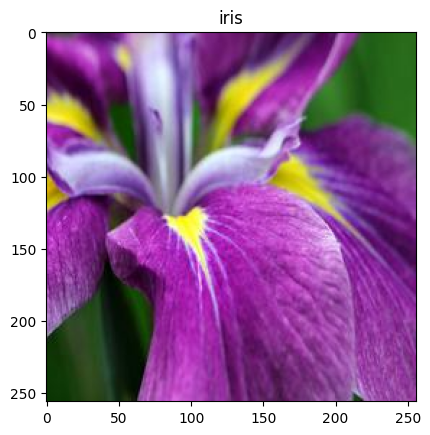

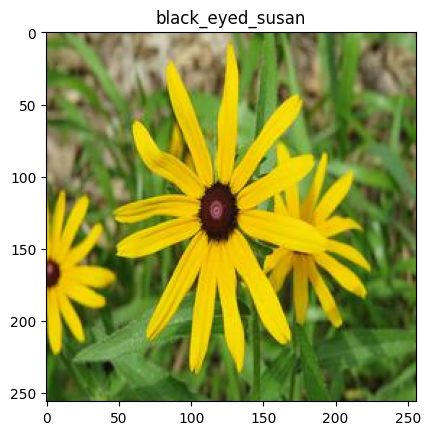

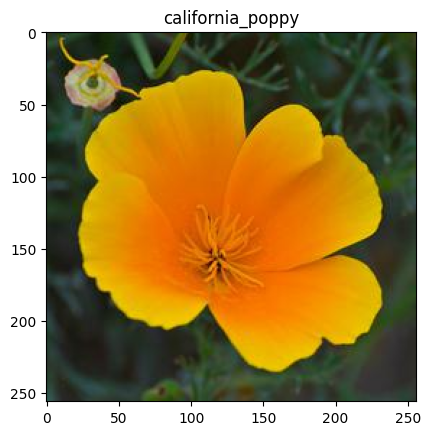

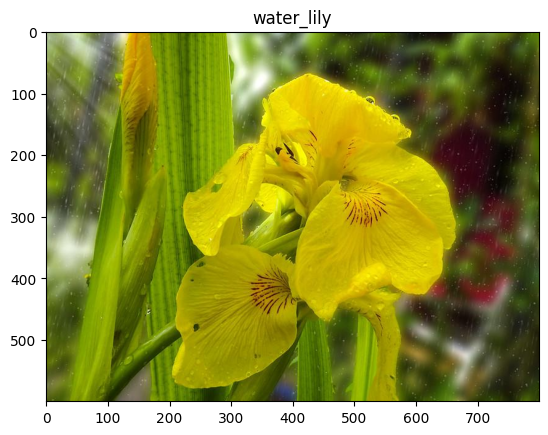

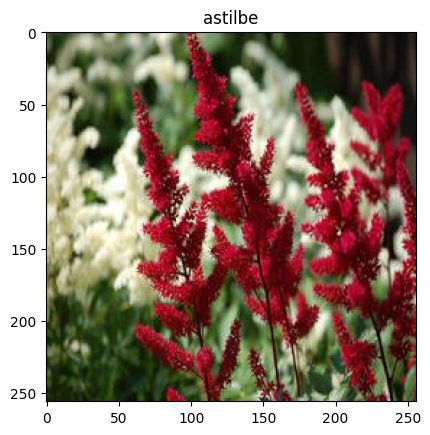

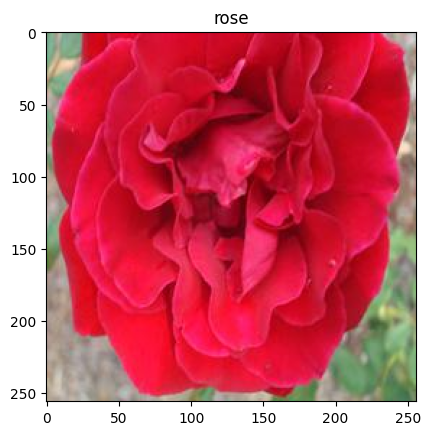

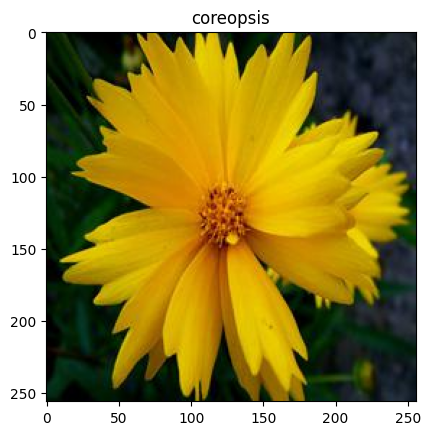

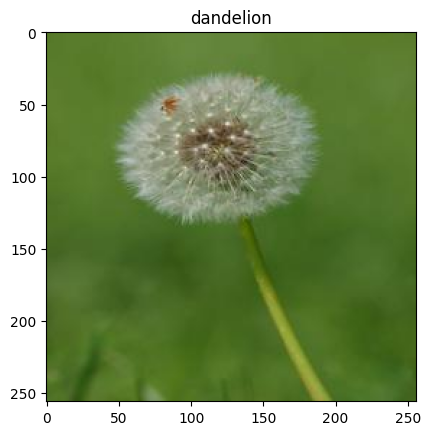

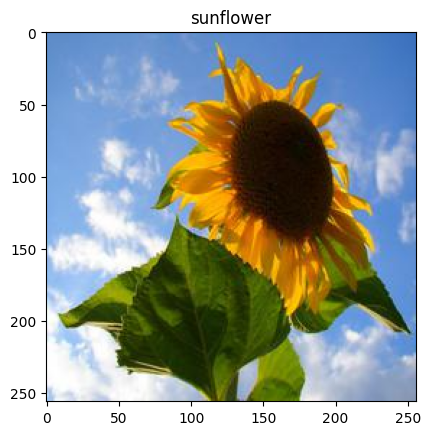

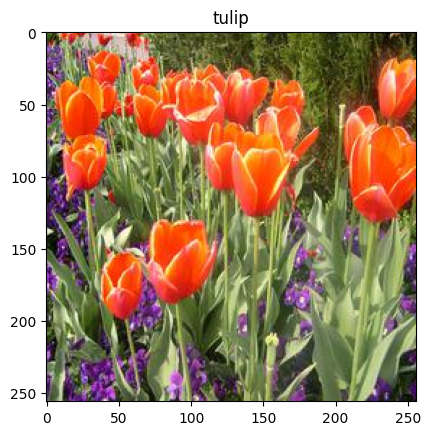

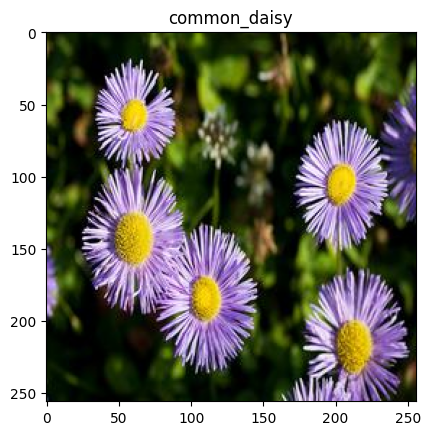

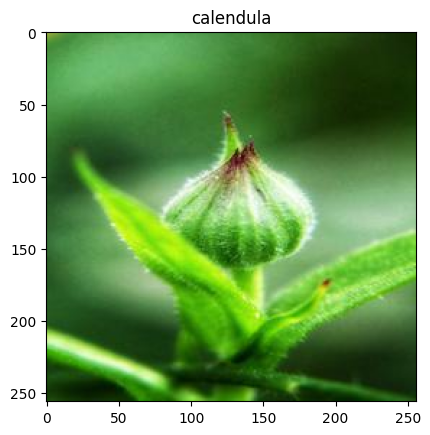

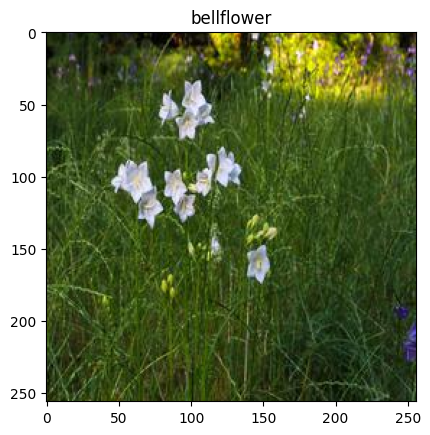

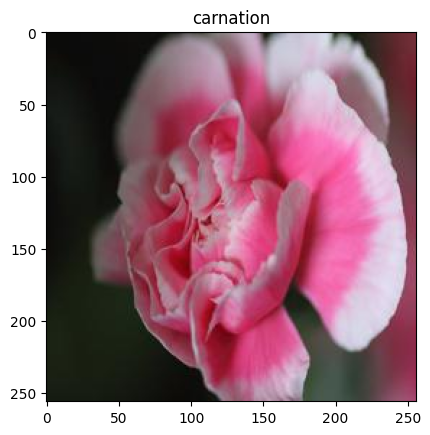

In [11]:
# Define the directory
dir_path = '/content/dataset/'

# Initialize a list to store the classes that have been displayed
displayed_classes = []

# Loop over the subdirectories in the directory
for subdir in os.listdir(dir_path):
    # Check if this class has been displayed
    if subdir not in displayed_classes:
        # Add this class to the list of displayed classes
        displayed_classes.append(subdir)

        # Get the path to the first image in this class
        image_path = os.path.join(dir_path, subdir, os.listdir(os.path.join(dir_path, subdir))[0])

        # Load and display the image
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.title(subdir)
        plt.show()

## Memisahkan Data Train dan Data Validation

In [12]:
# Gathering all filename from each category
base_dir = '/content/dataset'
categories = os.listdir(base_dir)
files = {category: os.listdir(os.path.join(base_dir, category)) for category in categories}

# Split the dataset into train set and validation set
train_set = {}
val_set = {}
for category, filenames in files.items():
    train, val = train_test_split(filenames, test_size=0.2, random_state=1)
    train_set[category] = train
    val_set[category] = val

In [13]:
#Check the amount of data training and validation
print('Amount of train data:', sum(len(files) for files in train_set.values()))
print('Amount of validation data:',sum(len(files) for files in val_set.values()))

Amount of train data: 10987
Amount of validation data: 2753


## Creating New Directory to Store The Train Data and Validation Data

In [14]:
train_dir = '/content/train'
val_dir = '/content/val'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Store the train_set and val_set into the new directory
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    for filename in train_set[category]:
        src = os.path.join(base_dir, category, filename)
        dst = os.path.join(train_dir, category, filename)
        shutil.copyfile(src, dst)

    for filename in val_set[category]:
        src = os.path.join(base_dir, category, filename)
        dst = os.path.join(val_dir, category, filename)
        shutil.copyfile(src, dst)

## Creating Data Augmentation using ImageDataGenerator

In [15]:
train_datagen = ImageDataGenerator(
                    preprocessing_function=preprocess_input,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    brightness_range=[0.8,1.2],
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
                    preprocessing_function=preprocess_input,
                    )

## Setting The Data Generator for Training dan Validation

In [16]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(250, 250),
        batch_size=32,
        seed=100,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(250, 250),
        batch_size=32,
        seed=100,
        class_mode='categorical')

Found 10987 images belonging to 14 classes.
Found 2753 images belonging to 14 classes.


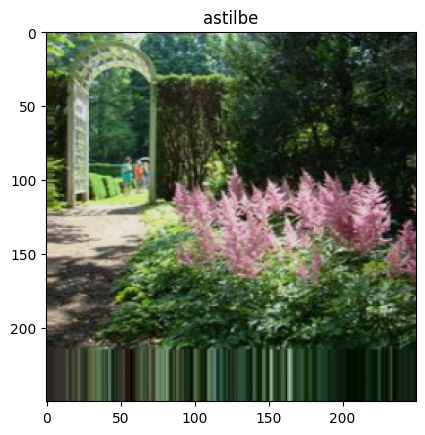

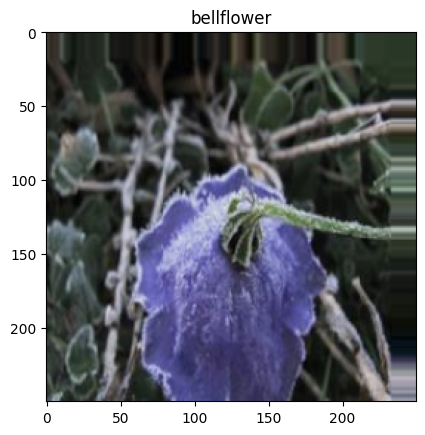

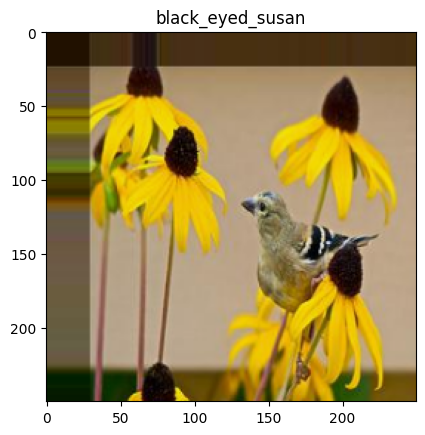

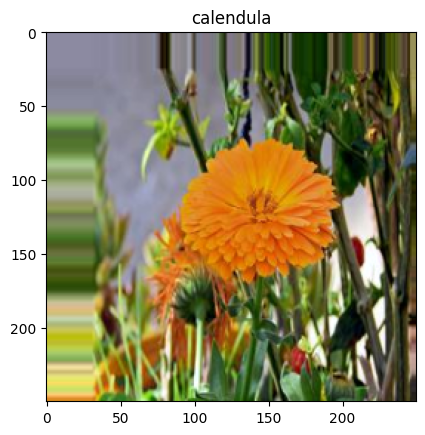

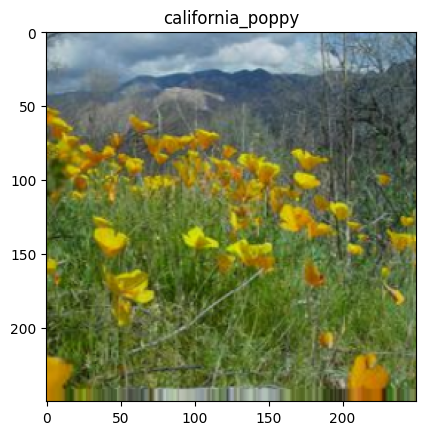

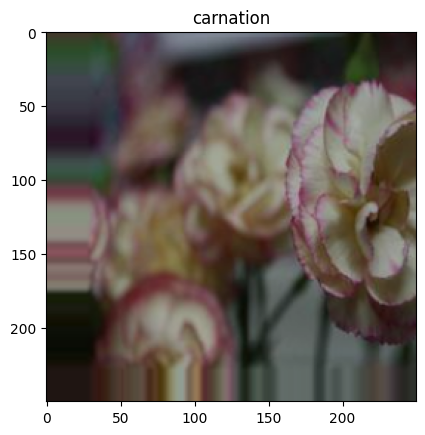

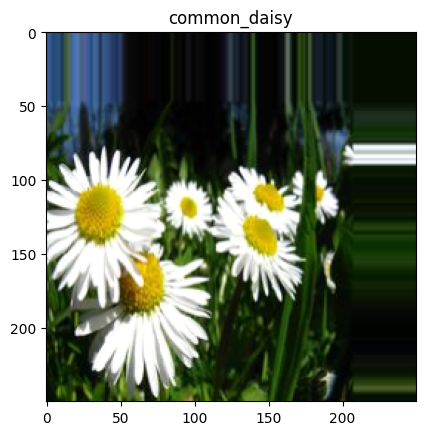

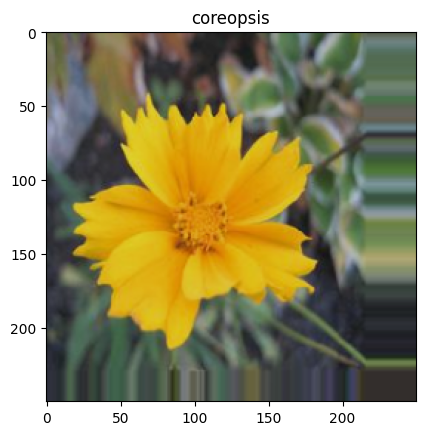

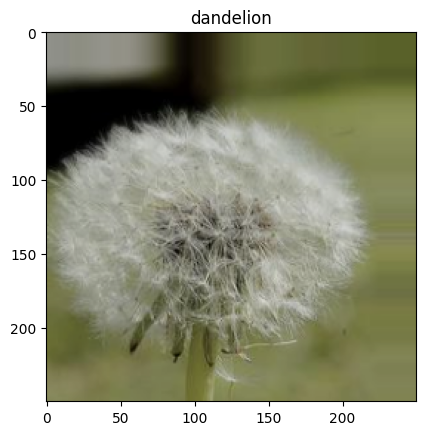

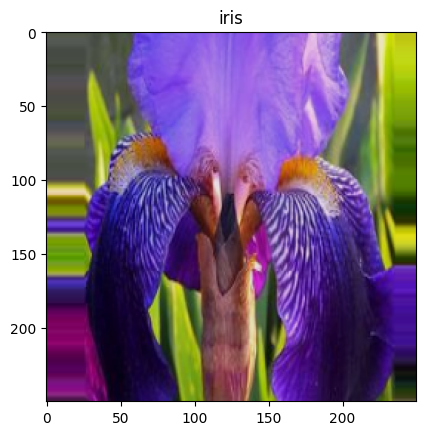

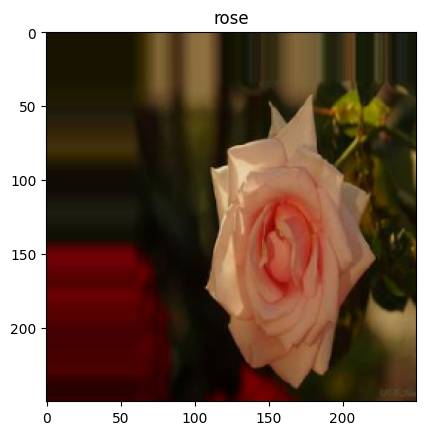

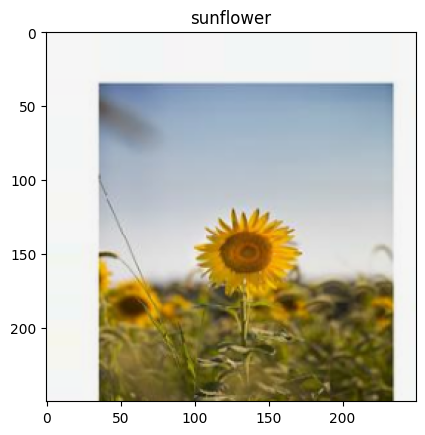

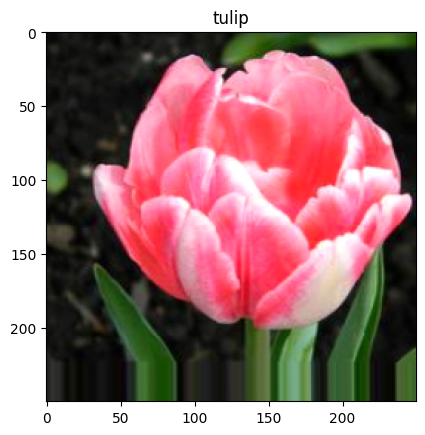

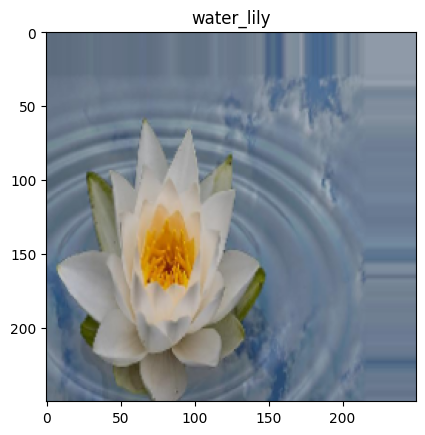

In [17]:
# Gather the class labels for train_generator
class_labels = list(train_generator.class_indices.keys())

for class_label in class_labels:
    # Getting one batch of images from train_generator
    images, labels = next(train_generator)

    # Finding the first image from each class in the batch
    for i in range(len(labels)):
        # Getting the one-hotted labels
        label = np.argmax(labels[i])

        # Display the images
        if class_labels[label] == class_label:
            image = images[i].astype("uint8")
            plt.imshow(image)
            plt.title(class_label)
            plt.show()
            break

## Modeling

### Base Model (MobileNetV3Large)

In [18]:
with tf.device('/gpu:0'):
  base_model = MobileNetV3Large(weights="imagenet", include_top=False, input_shape=(250,250, 3))
  base_model.trainable = False # Made the weight not trainable

  base_model.summary()

12683000/12683000 [==============================] - 0s 0us/step
Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 250, 250, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 125, 125, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 125, 125, 16)         64        ['Conv[0][0]']                
 lization)        

### Custom Model (CNN)

In [19]:
with tf.device('/gpu:0'):
  model = Sequential([
      base_model,

      Conv2D(512, (3,3), activation='relu'),
      MaxPooling2D(2, 2),

      GlobalAveragePooling2D(),

      Dropout(0.5),
      Dense(14, activation='softmax')
  ])

  print(model.summary())

  model.compile(optimizer= tf.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 8, 8, 960)         2996352   
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 512)         4424192   
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

## Train The Model

In [20]:
# Callback for saving best model
checkpoint = ModelCheckpoint('model/', save_best_only=True)

# Callback for saving log
csv_logger = CSVLogger('training_history.csv', separator=',', append=False)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

# Callback for Learning rate scheduler
initial_learning_rate = 0.001

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 5
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [21]:
with tf.device('/gpu:0'):
  history = model.fit_generator(
                  train_generator,
                  epochs=10,
                  validation_data=validation_generator,
                  verbose=1,
                  callbacks=[[checkpoint,
                              csv_logger,
                              es,
                              LearningRateScheduler(lr_step_decay)
                              ]]
            )

<ipython-input-21-c6592e5d5181>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
344/344 [==============================] - 222s 619ms/step - loss: 0.9275 - accuracy: 0.7846 - val_loss: 0.3063 - val_accuracy: 0.9117 - lr: 0.0010
Epoch 2/10
344/344 [==============================] - 207s 602ms/step - loss: 0.4313 - accuracy: 0.8668 - val_loss: 0.2722 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 3/10
344/344 [==============================] - 208s 604ms/step - loss: 0.3776 - accuracy: 0.8870 - val_loss: 0.2581 - val_accuracy: 0.9259 - lr: 0.0010
Epoch 4/10
344/344 [==============================] - 207s 601ms/step - loss: 0.3139 - accuracy: 0.9027 - val_loss: 0.2159 - val_accuracy: 0.9310 - lr: 0.0010
Epoch 5/10
344/344 [==============================] - 191s 555ms/step - loss: 0.2836 - accuracy: 0.9092 - val_loss: 0.2487 - val_accuracy: 0.9263 - lr: 0.0010
Epoch 6/10
344/344 [==============================] - 208s 604ms/step - loss: 0.2081 - accuracy: 0.9339 - val_loss: 0.1887 - val_accuracy: 0.9422 - lr: 5.0000e-04
Epoch 7/10
344/344 [======================

### Visualization/Evaluation

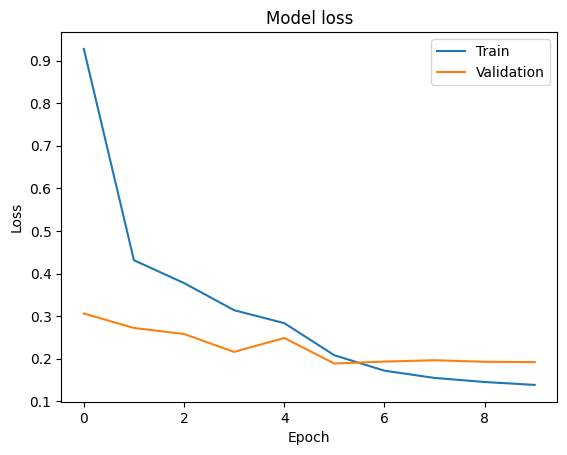

In [22]:
# Visualizing the loss function
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

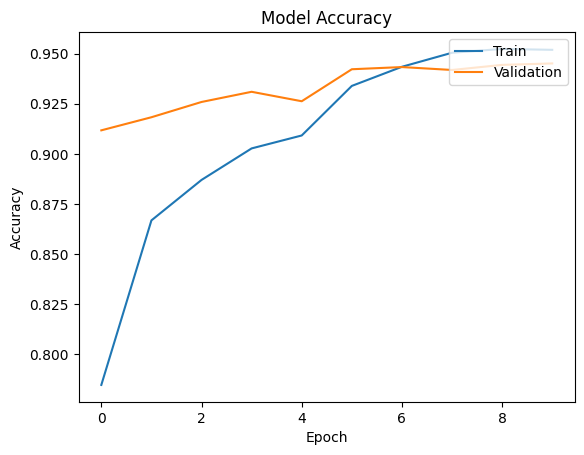

In [23]:
# Visualizing the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Prediction

Saving Ar3M9KZxZv8cj5RMXomg7B-1200-80.jpg to Ar3M9KZxZv8cj5RMXomg7B-1200-80 (3).jpg
1/1 [==============================] - 1s 1s/step
Predicted class: dandelion, Confidence: 1.00


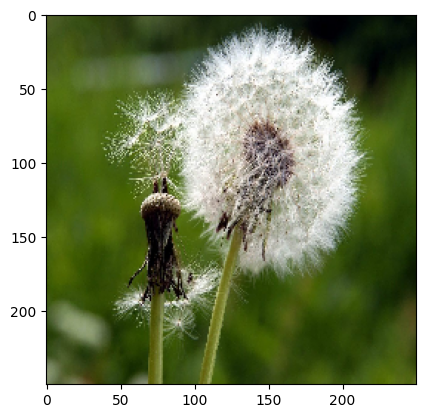

In [35]:
uploaded = fls.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(250,250))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(preprocess_input(images), batch_size=32)
  # Display the results
  predicted_class = class_labels[np.argmax(classes)]
  confidence = np.max(classes)
  print(f'Predicted class: {predicted_class}, Confidence: {confidence:.2f}')

## Save The Model

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to a .tflite file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model has been converted and saved as 'model.tflite'")

Model has been converted and saved as 'model.tflite'


Check List:
- Dataset yang akan dipakai bebas, namun minimal memiliki 1000 buah gambar. ✔️
- Dataset tidak pernah digunakan pada submission kelas machine learning sebelumnya. ✔️
- Dataset dibagi menjadi 80% train set dan 20% test set. ✔️
- Model harus menggunakan model sequential. ✔️
- Model harus menggunakan Conv2D Maxpooling Layer. ✔️
- Akurasi pada training dan validation set minimal sebesar 80%. ✔️
- Menggunakan Callback. ✔️
- Membuat plot terhadap akurasi dan loss model. ✔️
- Menulis kode untuk menyimpan model ke dalam format TF-Lite. ✔️

Check List for 5 Star
- Semua ketentuan terpenuhi ✔️
- Dataset memiliki minimal 10000 gambar ✔️
- Minimal 3 kelas ✔️
- Resolusi gambar pada dataset tidak seragam. ✔️
- Akurasi pada training set dan validation set minimal 92%. ✔️